In [47]:
import numpy as np 
import matplotlib.pyplot as plt

from scipy.optimize import newton

from utils import *

### create inverse problem

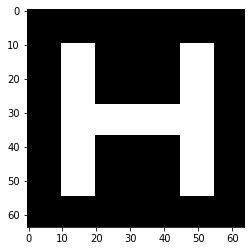

In [2]:
spread = [10,10]
size = 64
shape = (size, size)
pixels = shape[0] * shape[1]

x_true = build_x_true().reshape(-1,1)

plt.imshow(im(x_true, shape), cmap='Greys_r')

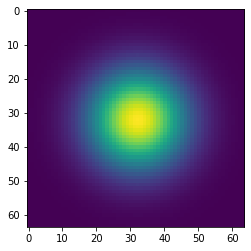

In [3]:
A = build_A(spread, shape)
plt.imshow(im(A[:, int(shape[0]**2/2 + shape[1]/2)], (size, size)))

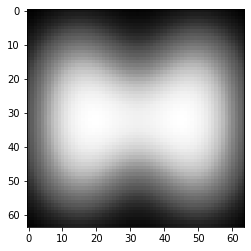

In [4]:
b_true = A @ x_true
plt.imshow(im(b_true, shape), cmap='Greys_r')

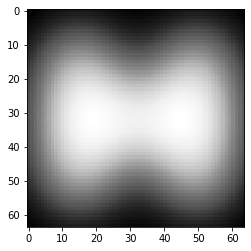

In [11]:
noise_level = 0.001
noise = np.random.randn(pixels)
e = noise_level * np.linalg.norm(b_true) / np.linalg.norm(noise) * noise
e = e.reshape(-1,1)
b = b_true + e

plt.imshow(im(b, shape), cmap='Greys_r')

### naive solution

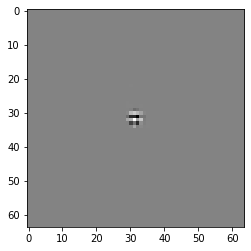

In [14]:
reconstruct = np.linalg.solve(A, b)
diff = np.max(reconstruct) - np.min(reconstruct)

plt.imshow(im(reconstruct, shape), cmap='Greys_r')

### solve with truncated svd

In [15]:
U, S, VT = np.linalg.svd(A)
V = VT.T

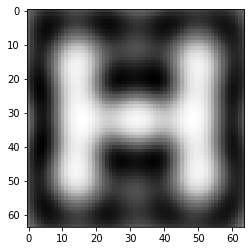

In [16]:
#choose the truncation parameter
r = 60
S_hat = S[0:r] #extract the first r singular values
S_hat_mat = np.diag(S_hat) #form a diagonal matrix
U_temp = U[:, 0:r]
x_trunc = np.transpose(VT[0:r, :])@np.linalg.inv(S_hat_mat)@np.transpose(U_temp)@b

plt.imshow(im(x_trunc, shape), cmap='Greys_r')

### solve with tikhonov regularization

Minima:
Lambda   =  0.000244140625
residual =  0.018036122050872145
error   =  0.3780422272994494
x_norm   =  30.851957345460445


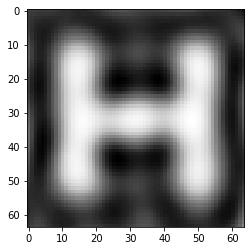

In [17]:
lamb = 1/16
minerror = 10000
lambdas = []
xnorms = []
residuals = []
while lamb > 1e-7:
    F = np.array([s/(s**2 + lamb**2) for s in S])
    x_reg = V @ np.diag(F) @ U.T @ b
    lambdas.append(lamb)
    xnorms.append(np.linalg.norm(x_reg))
    residuals.append(np.linalg.norm(A @ x_reg - b))
    error = np.linalg.norm(x_reg - x_true)/np.linalg.norm(x_true)
    if error < minerror:
        minerror = error
        minlamb = lamb
        minx = x_reg
        minxnorm = xnorms[-1]
        minresidual = residuals[-1]
    
    lamb /= 2
    
l_curve = list(zip(lambdas, residuals, xnorms))

print('Minima:')
print('Lambda   = ', minlamb)
print('residual = ', minresidual)
print('error   = ', minerror)
print('x_norm   = ', minxnorm)

plt.imshow(im(minx, shape), cmap='Greys_r')

### solve with arnoldi

In [18]:
Q, H = arnoldi(A, 10, b)

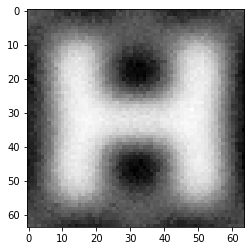

In [27]:
b_hat = Q.T @ b
y = np.linalg.solve( (H.T @ H), H.T @ b_hat)
x_arnoldi = Q[:,:-1] @ y

plt.imshow(im(x_arnoldi, shape), cmap='Greys_r')

### solve with arnoldi + tikhonov, arbitrary lambda

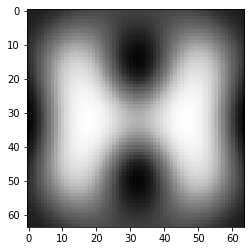

In [41]:
lamb_dah = 0.001

y_arnoldi_tikhonov = np.linalg.solve( (H.T @ H + lamb_dah * np.eye(10)), (H.T @ b_hat) )

x_arnoldi_tikhonov = Q[:,:-1] @ y_arnoldi_tikhonov

plt.imshow(im(x_arnoldi_tikhonov, shape), cmap='Greys_r')

### discrepancy principle

In [105]:
b_tilde = U.T @ b

eta = 1.0001

delta = np.linalg.norm(e)

discrepancy_func = lambda lamb_dah_d: (np.sum(np.array([lamb_dah_d**2 * b**2/(s**2 + lamb_dah_d**2) for (b,s) in list(zip(b_tilde, S))])) - (eta*delta)**2)**2

lambda_d = newton(discrepancy_func, 1, maxiter=100)

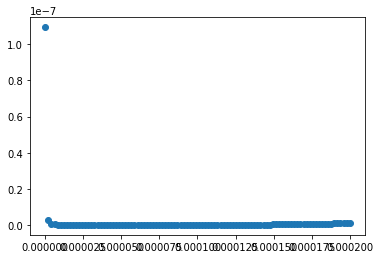

In [106]:
lamb_dahs = np.linspace(0,0.0002,100)

plt.scatter(lamb_dahs, [discrepancy_func(val) for val in lamb_dahs])

In [107]:
lambda_d

8.208420900739205e-05

In [108]:
x_tikhonov_d = np.linalg.solve( (A.T @ A + lambda_d * np.eye(4096)), (A.T @ b) )

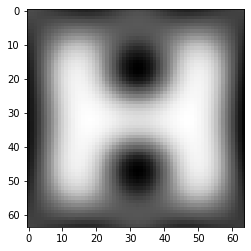

In [109]:
plt.imshow(im(x_tikhonov_d, shape), cmap='Greys_r')